# Amazon Bedrock boto3 Setup

---

In this demo notebook, we demonstrate how to use the [`boto3` Python SDK](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) to work with [Amazon Bedrock](https://aws.amazon.com/bedrock/) Foundation Models.

For more details refer to the [`Bedrock` Workshop](https://github.com/aws-samples/amazon-bedrock-workshop)

---

## Prerequisites

Run the cells in this section to install the packages needed by the notebooks in this workshop. ⚠️ You will see pip dependency errors, you can safely ignore these errors. ⚠️

IGNORE ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

In [1]:
%pip install --no-build-isolation --force-reinstall \
    "boto3>=1.28.57" \
    "awscli>=1.29.57" \
    "botocore>=1.31.57"
%pip install "unstructured[csv]" "pillow>=9.5,<10" langchain==0.0.309 python-weather pypdf==3.8.1 faiss-cpu==1.7.4 --force-reinstall --quiet

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 KB 1.2 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 20.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 23.8 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached s3transfer-0.10.0-py3-none-any.whl (82 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 KB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 KB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 KB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.5/230.5 KB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 KB 21.5 MB/s eta 0:00:00
  Attempting uninstall: jmespath
    Found existing installation: jmespath 1.0.1
    Uninstalling jmesp

In [1]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

## Bedrock clients
This notebook demonstrates invoking Bedrock models directly using the AWS SDK

Here are links for some packages you might not be familiar with:

- [FAISS](https://github.com/facebookresearch/faiss), to store vector embeddings
- [sqlalchemy](https://www.sqlalchemy.org/), SQLAlchemy is the Python SQL toolkit 
- [PyPDF](https://pypi.org/project/pypdf/), for handling PDF files
- [IPyWidgets](https://ipywidgets.readthedocs.io/en/stable/), for interactive UI widgets in the notebook
- [NeMo-Guardrails](https://github.com/NVIDIA/NeMo-Guardrails) an open-source toolkit for easily adding programmable guardrails to LLM-based conversational systems


---

## Create the boto3 client

Interaction with the Bedrock API is done via the AWS SDK for Python: [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html).

Depending on your environment, you might need to customize the setup when creating your Bedrock service client. To help with this, we've provided a `get_bedrock_client()` utility method that supports passing in different options. You can find the implementation in [../utils/bedrock.py](../utils/bedrock.py)

#### Use different clients
The boto3 provides different clients for Amazon Bedrock to perform different actions. The actions for [`InvokeModel`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModel.html) and [`InvokeModelWithResponseStream`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModelWithResponseStream.html) are supported by Amazon Bedrock Runtime where as other operations, such as [ListFoundationModels](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_ListFoundationModels.html), are handled via [Amazon Bedrock client](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_Operations_Amazon_Bedrock.html).

The `get_bedrock_client()` method accepts `runtime` (default=True) parameter to return either `bedrock` or `bedrock-runtime` client.

#### Use the default credential chain

If you are running this notebook from [Amazon Sagemaker Studio](https://aws.amazon.com/sagemaker/studio/) and your Sagemaker Studio [execution role](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) has permissions to access Bedrock you can just run the cells below as-is. This is also the case if you are running these notebooks from a computer whose default AWS credentials have access to Bedrock.

#### Use a different AWS Region

If you're running this notebook from your own computer or a SageMaker notebook in a different AWS Region from where Bedrock is set up, you can un-comment the `os.environ['AWS_DEFAULT_REGION']` line below and specify the region to use.

#### Use a specific profile

In case you're running this notebook from your own computer where you have setup the AWS CLI with multiple profiles, and the profile which has access to Bedrock is not the default one, you can un-comment the `os.environ['AWS_PROFILE']` line below and specify the profile to use.

#### Use a different role

In case you or your company has setup a specific, separate [IAM Role](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles.html) to access Bedrock, you can specify it by un-commenting the `os.environ['BEDROCK_ASSUME_ROLE']` line below. Ensure that your current user or role have permissions to [assume](https://docs.aws.amazon.com/STS/latest/APIReference/API_AssumeRole.html) such role.

#### A note about `langchain`

The Bedrock classes provided by `langchain` create a Bedrock boto3 client by default. To customize your Bedrock configuration, we recommend to explicitly create the Bedrock client using the method below, and pass it to the [`langchain.Bedrock`](https://python.langchain.com/docs/integrations/llms/bedrock) class instantiation method using `client=boto3_bedrock`

In [3]:
import json
import os
import sys
import boto3
import botocore

module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils import bedrock, print_ww


# ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----

os.environ["AWS_DEFAULT_REGION"] = "us-east-1"
os.environ["AWS_PROFILE"] = "sebas"
#os.environ["BEDROCK_ASSUME_ROLE"] = ""  # E.g. "arn:aws:..."

bedrock_runtime = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None))

model_parameter = {"temperature": 0.0, "top_p": .5, "max_tokens_to_sample": 2000}

Create new client
  Using region: us-east-1
  Using profile: sebas
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)


## Invoke Model

we will demonstrate the use of invoking the models and also highlight the default behaviour of LLM. They will return answer and data based on the training data. For our use case of AiStylist we need more curated responses. That means we will need to adopt a different architecture to get the model to execute our use case. Those techniques will be demonstrated in the next workbook

In [4]:
# If you'd like to try your own prompt, edit this parameter!
customer_input = "I am a male consultant in my 30s traveling to New York next week. What kind of outfit should I wear on my first day in the office? "

In [18]:
# first fetch possible styles and give options to customer
prompt = """

Human: list different style options for:
""" + customer_input + """

Assistant:"""

body = json.dumps({"prompt": prompt, "max_gen_len": 2048, "temperature": 0.5, "top_p":0.9})
modelId = "meta.llama2-70b-chat-v1"  # change this to use a different version from the model provider
accept = "application/json"
contentType = "application/json"


response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
    )
response_body = json.loads(response.get("body").read())
styles_response = response_body.get("generation")
print(styles_response)

 Sure, I can help you with that! Here are a few different style options you could consider for your first day in the office:

1. Classic Business Attire: A well-tailored navy blue or charcoal gray suit, white dress shirt, and a tie in a neutral color like black, navy, or gray. This is a timeless and professional look that is appropriate for most business settings.
2. Modern Business Casual: A navy blazer or sports coat, a dress shirt in a light color like white or light blue, and dress pants in a neutral color like gray or khaki. This look is a bit more relaxed than a full suit, but still professional and polished.
3. Trendy Tech Startup: A slim-fit black or dark gray T-shirt, a pair of well-fitted jeans, and a black leather jacket or a denim jacket. This look is perfect for a tech startup or a creative industry, and it exudes a sense of cool, urban sophistication.
4. Classic Preppy: A navy blazer, a dress shirt in a bold color like red or yellow, and khaki pants. This look is classic,

## Generate the default images using stability.stable-diffusion-xl

Preparing received response to generate images for each style look

In [26]:
# Prepare input for fetching images for each of style
styles = [s.strip() for s in (list(filter(None, styles_response.splitlines()))[1:-1])]
print(*styles, sep='\n')

1. Classic Business Attire: A well-tailored navy blue or charcoal gray suit, white dress shirt, and a tie in a neutral color like black, navy, or gray. This is a timeless and professional look that is appropriate for most business settings.
2. Modern Business Casual: A navy blazer or sports coat, a dress shirt in a light color like white or light blue, and dress pants in a neutral color like gray or khaki. This look is a bit more relaxed than a full suit, but still professional and polished.
3. Trendy Tech Startup: A slim-fit black or dark gray T-shirt, a pair of well-fitted jeans, and a black leather jacket or a denim jacket. This look is perfect for a tech startup or a creative industry, and it exudes a sense of cool, urban sophistication.
4. Classic Preppy: A navy blazer, a dress shirt in a bold color like red or yellow, and khaki pants. This look is classic, timeless, and appropriate for a variety of business settings.
5. Modern Minimalist: A simple white or light gray T-shirt, a p

In [39]:
styles[0].split('-')

['1. Classic Business Attire: A well',
 'tailored navy blue or charcoal gray suit, white dress shirt, and a tie in a neutral color like black, navy, or gray. This is a timeless and professional look that is appropriate for most business settings.']

1. Classic Business Attire: A well-tailored navy blue or charcoal gray suit, white dress shirt, and a tie in a neutral color like black, navy, or gray. This is a timeless and professional look that is appropriate for most business settings.


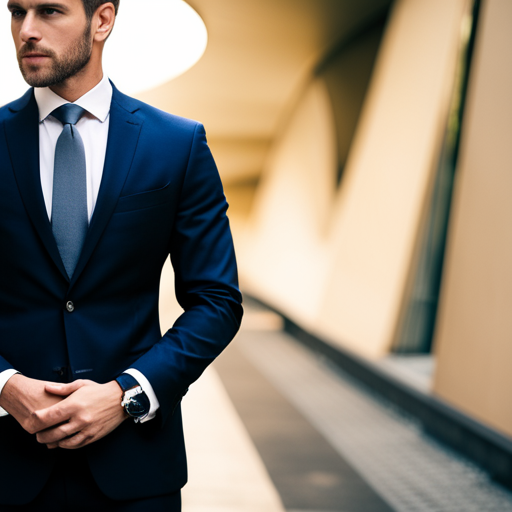

2. Modern Business Casual: A navy blazer or sports coat, a dress shirt in a light color like white or light blue, and dress pants in a neutral color like gray or khaki. This look is a bit more relaxed than a full suit, but still professional and polished.
3. Trendy Tech Startup: A slim-fit black or dark gray T-shirt, a pair of well-fitted jeans, and a black leather jacket or a denim jacket. This look is perfect for a tech startup or a creative industry, and it exudes a sense of cool, urban sophistication.


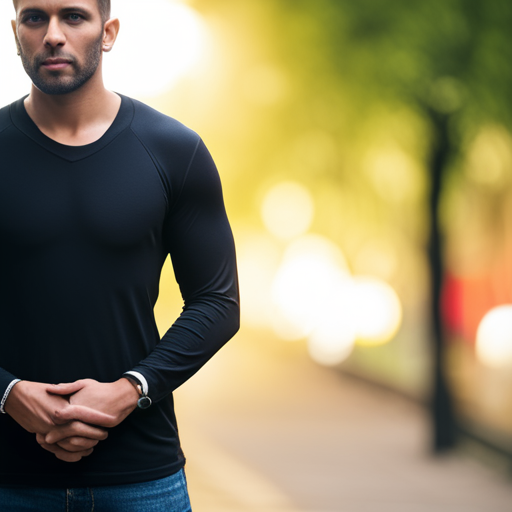

4. Classic Preppy: A navy blazer, a dress shirt in a bold color like red or yellow, and khaki pants. This look is classic, timeless, and appropriate for a variety of business settings.
5. Modern Minimalist: A simple white or light gray T-shirt, a pair of black or dark gray jeans, and a black leather jacket or a denim jacket. This look is clean, modern, and perfect for a minimalist style.


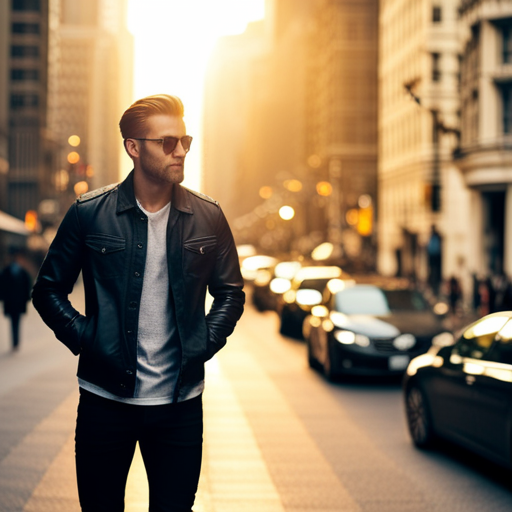

In [29]:
from PIL import Image
from IPython import display
from base64 import b64decode
import base64
import io
import json
import os
import sys

# Fetching images for each of style

os.makedirs("data", exist_ok=True)
images = []
for i, style in enumerate(styles):
    print(style)
    if len(style.split("-")) > 1:
        request = json.dumps({
            "text_prompts": (
                [{"text": "person wearing " + style.split("-")[1], "weight": 1.0}]
            ),
            "cfg_scale": 5,
            "seed": 5450,
            "steps": 70,
            "style_preset": "photographic",
        })
        modelId = "stability.stable-diffusion-xl"
        
        response = bedrock_runtime.invoke_model(body=request, modelId=modelId)
        response_body = json.loads(response.get("body").read())
        
        base_64_img_str = response_body["artifacts"][0].get("base64")
        display.display(display.Image(b64decode(base_64_img_str), width=200))